In [1]:
import requests, pandas as pd, matplotlib.pyplot as plt

In [2]:
# kubectl port-forward svc/router 8888:80 -n fission
BASE_URL = "http://127.0.0.1:8888/data-filter"

In [18]:
payload = {
    "content": [
        "cost", "rent", "price", "grocery", "transport", "bill", "living", "wage", "income", "expensive", "afford",
        "renting", "apartment", "real estate", "landlord", "tenant", "lease", "mortgage", "housing", "electricity",
        "gas", "water", "utility", "power bill", "food", "meal", "dining", "supermarket", "shopping", "financial",
        "budget", "ripoff", "overpriced", "cheapest", "cheaper", "cheap", "struggle", "student loan", "university",
        "school", "tuition", "doctor", "hospital", "medicare", "insurance", "healthcare", "uber", "taxi",
        "public transport", "car", "petrol", "fuel"],   # data.content
    "tags":     [],     # data.tags
    "keywords": [],     # keywords
    "combine":  "or",      # "and" | "or"
    "size":     1000,
    "max_docs": 5000       # maximum return data
}

In [19]:
resp = requests.post(BASE_URL, json=payload, timeout=120)
resp.raise_for_status()

data = resp.json()
print("Total hits:", data["total"])

HTTPError: 500 Server Error: Internal Server Error for url: http://127.0.0.1:8888/data-filter

In [6]:
docs = resp.json()["data"]
records = []
for d in docs:
    record = {
        "sentiment": d.get("sentiment"),
        "platform": d.get("platform"),
        "_id": d.get("_id"),
        "sentimentLabel": d.get("sentimentLabel"),
        "keywords": d.get("keywords"),
        "tags": d.get("data", {}).get("tags"),
        "createdAt": d.get("data", {}).get("createdAt"),
    }
    records.append(record)
df = pd.DataFrame(records)
df["createdAt"] = (
    df["createdAt"]
      .astype(str)
      .str.replace(r"\+00:00Z$", "Z", regex=True)
)
df.head()

In [7]:
def plot_city_sentiment(df, cities=["melbourne", "sydney", "brisbane"]):
    df["createdAt"] = pd.to_datetime(df["createdAt"], errors="coerce")
    
    df["month"] = df["createdAt"].dt.to_period("M")

    # 3. 展开 keywords 列（如果为 list）
    df_exploded = df.explode("keywords")

    # 4. 只保留感兴趣的城市关键词
    df_filtered = df_exploded[df_exploded["keywords"].isin(cities)]

    # 5. 计算每月每城市的平均情绪值
    grouped = (
        df_filtered.groupby(["month", "keywords"])["sentiment"]
        .mean()
        .unstack(fill_value=0)
    )

    # 6. 绘图
    ax = grouped.plot(
        kind="bar",
        stacked=True,
        figsize=(15, 6),
        colormap="Set2"
    )
    ax.set_title("Average Sentiment per Month by City")
    ax.set_ylabel("Average Sentiment")
    ax.set_xlabel("Month")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.grid(True)
    plt.show()

    return grouped  # 如果你还想进一步处理数据

/var/folders/gh/z6qvcxns38g4v5htj2mbv7l80000gn/T/ipykernel_57213/2231487073.py:6: UserWarning: Converting to PeriodArray/Index representation will drop timezone information.
  df["month"] = df["createdAt"].dt.to_period("M")


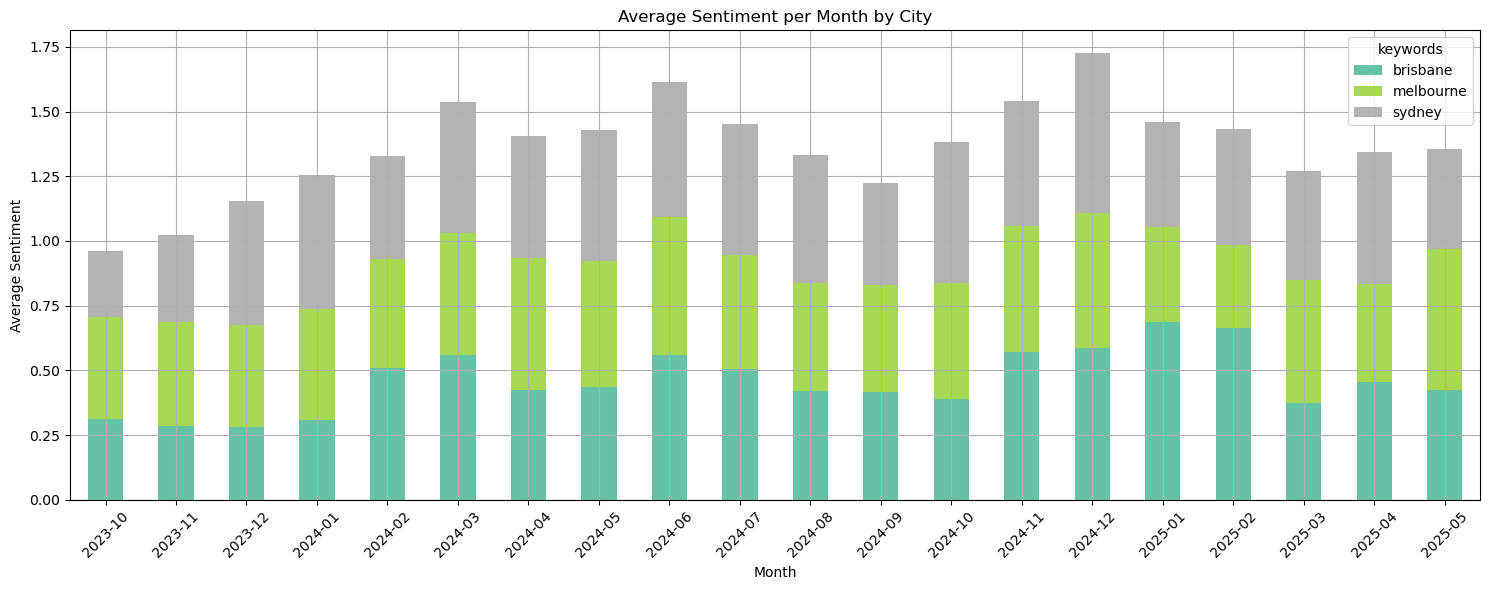

In [8]:
grouped_df = plot_city_sentiment(df)